In [22]:
from meta_transformer import transformer
import jax
from jax import random, vmap, grad, jit, value_and_grad
import jax.numpy as jnp
import haiku as hk
from jax import nn
from meta_transformer import utils
import optax
import numpy as np
import matplotlib.pyplot as plt
import time
import functools
import datasets
import dataclasses
from typing import Mapping, Any, Tuple, List, Iterator
import chex


rng = random.PRNGKey(42)
PATCH = False


# Model
def forward(image_batch, is_training=True):
    rng = hk.next_rng_key()
    input_chunks = utils.process_batch(
        rng, 
        image_batch, 
        patch=PATCH, 
        augment=True
    )
    t = transformer.Classifier(
        transformer=transformer.Transformer(
            num_heads=2, #4,
            num_layers=6,
            key_size=32,
            dropout_rate=0.1,
        ),
        model_size=64,
        num_classes=10,
    )
    return t(input_chunks, is_training=is_training)


model = hk.transform(forward)


@functools.partial(jit, static_argnums=3)
def loss(params, rng, data, is_training=True):
    """data is a dict with keys 'img' and 'label'."""
    images, targets = data["img"], data["label"]
    targets = nn.one_hot(targets, 10)
    logits = model.apply(params, rng, images, is_training)[:, 0, :]  # [B, C]
    chex.assert_equal_shape([logits, targets])
    return -jnp.sum(targets * nn.log_softmax(logits, axis=-1), axis=-1).mean()


# Data and metrics
train_data, test_data = utils.load_data("cifar10")


@functools.partial(jit, static_argnums=3)
def accuracy(rng, params, data, is_training=True):
    """data is a dict with keys 'img' and 'label'. labels are NOT one-hot."""
    targets, inputs = data["label"], data["img"]
    logits = model.apply(params, rng, inputs, is_training)[:, 0, :]
    predictions = jnp.argmax(logits, axis=-1)
    return jnp.mean(predictions == targets)


@jit
def val_metrics(rng, params):
    """Compute acc and loss on test set."""
    rngs = random.split(rng, 3)
    tdata = test_data[:]
    acc = accuracy(rngs[1], params, tdata, is_training=False)
    l = loss(params, rngs[2], tdata, is_training=False)
    return {"val/acc": acc, "val/loss": l}


Found cached dataset cifar10 (/home/lauro/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 867.85it/s]


In [23]:
# Optimizer and update function
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-3
BATCH_SIZE = 2048
NUM_EPOCHS = 250
opt = optax.adamw(LEARNING_RATE, weight_decay=WEIGHT_DECAY)


@chex.dataclass
class TrainState:
    step: int
    rng: random.PRNGKey
    opt_state: optax.OptState
    params: dict


class Updater: # Could also make this a function of opt.update, loss_fn, model.apply, etc if we want to be flexible
    """Holds training methods. All methods are jittable."""
    @functools.partial(jit, static_argnums=0)
    def init_params(self, rng: jnp.ndarray, data: dict) -> dict:
        """Initializes state of the updater."""
        out_rng, k0, k1 = jax.random.split(rng, 3)
        params = model.init(k1, data["img"])
        opt_state = opt.init(params)
        return TrainState(
            step=0,
            rng=out_rng,
            opt_state=opt_state,
            params=params,
        )
    
    @functools.partial(jit, static_argnums=0)
    def update(self, state: TrainState, data: dict) -> TrainState:
        state.rng, *subkeys = jax.random.split(state.rng, 3)
        grads = grad(loss)(state.params, subkeys[1], data)       
        updates, state.opt_state = opt.update(grads, state.opt_state, state.params)
        state.params = optax.apply_updates(state.params, updates)
        state.step += 1
        return state

    @functools.partial(jit, static_argnums=0)
    def compute_validation_metrics(self, state: TrainState) -> Tuple[TrainState, dict]:
        state.rng, subkey = random.split(state.rng)
        return state, val_metrics(subkey, state.params)
    
    @functools.partial(jit, static_argnums=0)
    def compute_metrics(self, state: TrainState, data: dict) -> Tuple[TrainState, dict]:
        state.rng, *subkeys = random.split(state.rng, 4)
        train_acc = accuracy(subkeys[1], state.params, data)
        train_loss = loss(state.params, subkeys[2], data)
        state, val_metrics = self.compute_validation_metrics(state)
        return state, {
            "train/acc": train_acc, 
            "train/loss": train_loss,
            "step": state.step,
            **val_metrics
            }

In [24]:
updater = Updater()
state = updater.init_params(rng, train_data[:2])
print("Number of parameters:", sum([x.size for x in jax.tree_util.tree_leaves(state.params)]) / 1e6, "Million")
metrics_list = []

Number of parameters: 0.325834 Million


In [25]:
train_images, train_labels = train_data["img"], train_data["label"]

In [26]:
def shuffle_data(rng: jnp.ndarray, images: jnp.ndarray, labels: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Shuffle the data."""
    idx = jnp.arange(len(images))
    idx = random.permutation(rng, idx)
    return images[idx], labels[idx]


def data_iterator(images: jnp.ndarray, labels: jnp.ndarray, batchsize: int = 1048, skip_last: bool = False) -> Iterator[Tuple[jnp.ndarray, jnp.ndarray]]:
    """Iterate over the data in batches."""
    for i in range(0, len(images), batchsize):
        if skip_last and i + batchsize > len(images):
            break
        yield dict(img=images[i:i + batchsize], 
                   label=labels[i:i + batchsize])

In [27]:
for epoch in range(NUM_EPOCHS):
    rng, subkey = random.split(rng)
    images, labels = shuffle_data(subkey, train_images, train_labels)
    batches = data_iterator(images, labels, batchsize=BATCH_SIZE, skip_last=True)
    for batch in batches:
        if state.step % 25 == 0:
            state, metrics = updater.compute_metrics(state, batch)
            metrics_list.append(metrics)
            print("Epoch:", epoch, "Step:", state.step, "Train acc:", metrics["train/acc"], "Val acc:", metrics["val/acc"])
        state = updater.update(state, batch)

Epoch: 0 Step: 0 Train acc: 0.10449219 Val acc: 0.1042
Epoch: 1 Step: 25 Train acc: 0.14990234 Val acc: 0.1549
Epoch: 2 Step: 50 Train acc: 0.18945312 Val acc: 0.2021
Epoch: 3 Step: 75 Train acc: 0.19628906 Val acc: 0.22289999
Epoch: 4 Step: 100 Train acc: 0.23144531 Val acc: 0.23259999
Epoch: 5 Step: 125 Train acc: 0.24316406 Val acc: 0.2536
Epoch: 6 Step: 150 Train acc: 0.26220703 Val acc: 0.259
Epoch: 7 Step: 175 Train acc: 0.28173828 Val acc: 0.27629998
Epoch: 8 Step: 200 Train acc: 0.27685547 Val acc: 0.2893
Epoch: 9 Step: 225 Train acc: 0.3017578 Val acc: 0.3011
Epoch: 10 Step: 250 Train acc: 0.2861328 Val acc: 0.2927
Epoch: 11 Step: 275 Train acc: 0.29736328 Val acc: 0.3143
Epoch: 12 Step: 300 Train acc: 0.31591797 Val acc: 0.326
Epoch: 13 Step: 325 Train acc: 0.32080078 Val acc: 0.32979998
Epoch: 14 Step: 350 Train acc: 0.32861328 Val acc: 0.3356
Epoch: 15 Step: 375 Train acc: 0.3310547 Val acc: 0.3407
Epoch: 16 Step: 400 Train acc: 0.34326172 Val acc: 0.3475
Epoch: 17 Step: 42

In [28]:
patch_metrics = utils.dict_concatenate(metrics_list)

if PATCH:
    patch_metrics = utils.dict_concatenate(metrics_list)
else:
    chunk_metrics = utils.dict_concatenate(metrics_list)

In [29]:
def plot_metrics(metrics: dict, axs: np.ndarray, prefix: str = ""):
    # acc
    ax = axs[0]
    # ax.plot(metrics["step"], metrics["train/acc"], label=prefix + "train acc")
    ax.plot(metrics["step"], metrics["val/acc"], label=prefix + "val acc")
    ax.set_ylabel("Training Accuracy")
    ax.set_xlabel("Step")
    ax.legend()

    # loss
    ax = axs[1]
    # ax.plot(metrics["step"], metrics["train/loss"], label="prefix + train loss")
    ax.plot(metrics["step"], metrics["val/loss"], label="prefix + val loss")
    ax.set_ylabel("Training Loss")
    ax.set_xlabel("Step")
    ax.set_yscale("log")
    ax.legend()

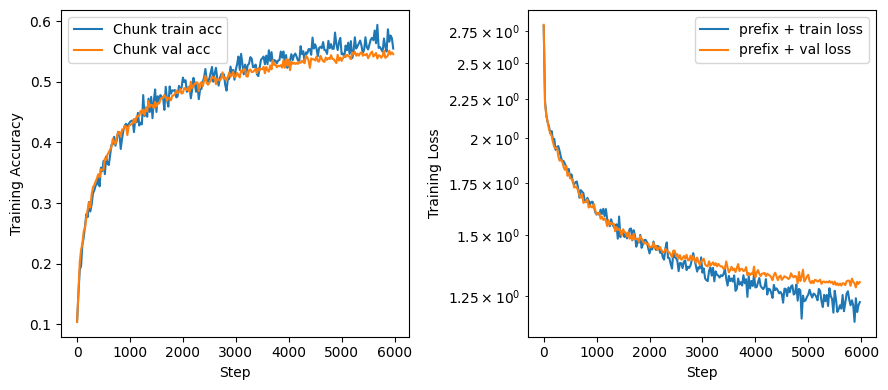

In [30]:
# Plot
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
plot_metrics(chunk_metrics, axs, prefix="Chunk ")
# plot_metrics(patch_metrics, axs, prefix="Patch ")
fig.tight_layout()
plt.show()